In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import torch

from mucstpy.utils import (read_10x_visium, data_augmentation, construction_interaction, add_contrastive_label, get_feature)
from mucstpy.image_feature import ImageFeature, image_crop
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


### Please change data path to your dir_path here

In [2]:
section = '151673'

data_path = 'D:/st_projects/data/DLPFC'
# load 10 X DLPFC dataset as benchmark
adata = read_10x_visium(path=os.path.join(data_path, section), count_file=section + '_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs['ground_truth'] = pd.read_csv(os.path.join(data_path, section) + '/' + section + '_truth.txt', sep='\t', header=None, index_col=0)

cluster_num = pd.get_dummies(adata.obs['ground_truth']).shape[1]
cluster_num

7

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
adata.raw = adata
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)

sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
# sc.pp.scale(adata)

In [4]:
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)

adata = image_crop(adata, crop_size=112, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 3639 × 11353
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'ground_truth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'

### Calculatet the spatial network, where edges are weighted by morphological similarity

In [5]:
from sklearn.metrics import pairwise_distances

construction_interaction(adata, n_neighbor=6)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity
adata.obsm['mor_adj'] = adj_spatial_mor

### Plot the network for all spots

Maximum weight: 1.0



(2697.7, 11460.3, -12041.35, -1979.65)

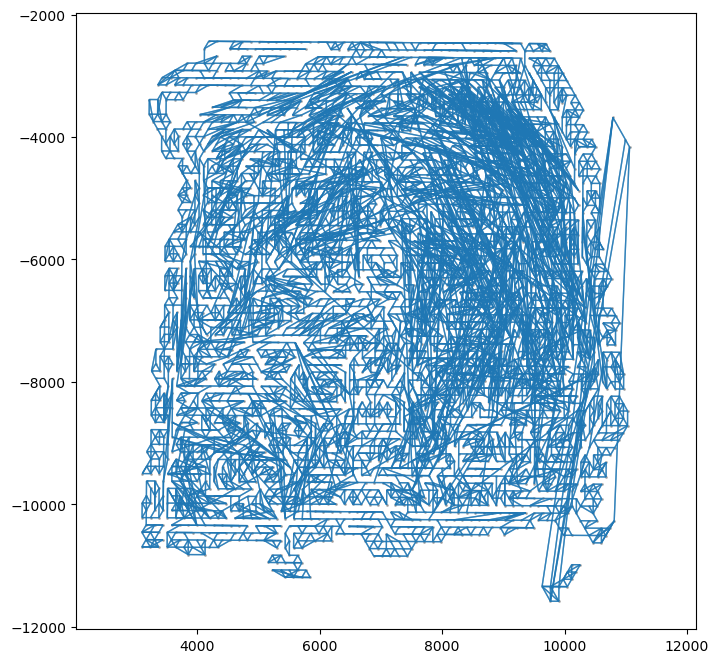

In [6]:
from mucstpy.utils import plot_graph_weights
from scipy import sparse
import matplotlib.pyplot as plt

position = adata.obsm['spatial'].copy()
position[:, 1] = -position[:, 1]
interaction = np.zeros_like(morphological_similarity)
for i in range(morphological_similarity.shape[0]):
    vec = morphological_similarity[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(1, 3 + 1):
        y = distance[t]
        interaction[i, y] = 1
    
interaction = interaction + interaction.T
interaction = np.where(interaction > 1, 1, interaction)

plot_graph_weights(position, sparse.csr_matrix(interaction), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [7]:
data_augmentation(adata)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [9]:
from mucstpy.MuCST import train_model

add_contrastive_label(adata)
get_feature(adata)

gene_dims=[adata.shape[1], 64]
img_dims=[adata.obsm['image_feature'].shape[1], 64]
project_dims=[64, 32]

train_model(adata, gene_dims=gene_dims, img_dims=img_dims, proj_dims=project_dims, lamb1=0.3, device=device)

Begin to train MuCST...


# Epoch 1499, loss: 0.979, g2g_loss: 0.259, gene_recon: 0.952, image_recon: 0.004:  97%|█████████▋| 1498/1550 [00:31<00:01, 47.85it/s]

# Epoch 1500, loss: 114.413, g2g_loss: 0.259, gene_recon: 0.952, image_recon: 0.004
Init finished, start contrastive learning part


# Epoch 1549, loss: 19.416, g2i_loss: 9.391, g2g_loss: 1.322, i2i_loss: 8.895, gene_recon: 0.995, image_recon: 0.009: 100%|██████████| 1550/1550 [01:36<00:00, 16.02it/s]   


Optimization of MuCST finished


In [10]:
# scale the expression to [0, 1]
def relative_func(expres):
    #expres: an array counts expression for a gene
    maxd = np.max(expres) - np.min(expres)
    min_exp = np.min(expres)
    rexpr = (expres - min_exp) / maxd
    return rexpr

In [11]:
raw_exp = adata.X.A
raw_exp = pd.DataFrame(raw_exp)
rec_exp = pd.DataFrame(adata.obsm['rec_feature'])

raw_exp.index = adata.obs.index
raw_exp.columns = adata.var.index
rec_exp.index = adata.obs.index
rec_exp.columns = adata.var.index

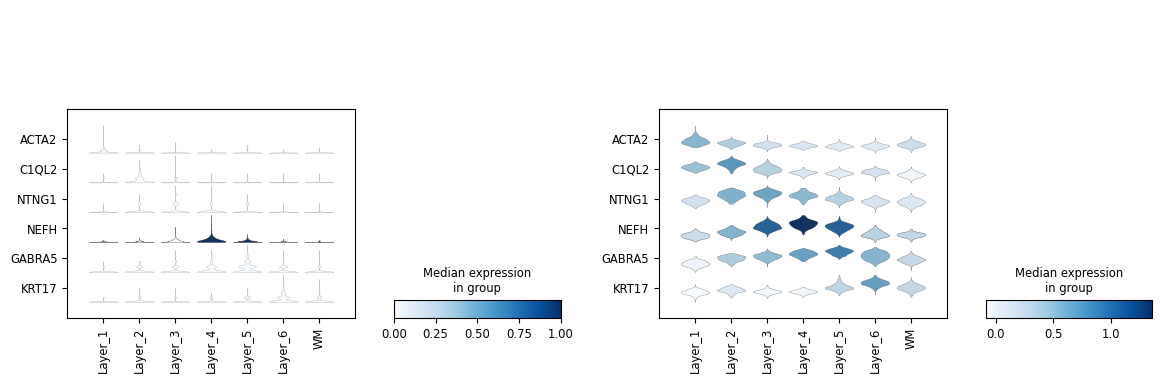

In [12]:
plot_gene = ['KRT17', 'GABRA5', 'NEFH', 'NTNG1', 'C1QL2', 'ACTA2'][::-1]
# marker_genes = ['S100B', 'KRT17', 'GABRA5', 'NEFH', 'NTNG1', 'C1QL2', 'ACTA2' ]
# marker_genes = marker_genes[::-1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sc.pl.stacked_violin(adata, var_names=plot_gene, groupby='ground_truth', swap_axes=True, ax=axs[0], show=False)
sc.pl.stacked_violin(adata, var_names=plot_gene, groupby='ground_truth', layer='My_ReX', swap_axes=True, ax=axs[1], show=False)
# plt.savefig('images/dlpfc_raw_enhance_gene_stacked_violin.eps', dpi=300, format='eps')
plt.show()

### Training a simple MLP-based Classifier Based on a Fixed Proportion of Labeled Data

In [13]:
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, num_dim, num_class):
        super(MLPClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(num_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_class)
        )

    def forward(self, x):
        return self.network(x)

In [14]:
adata_full = adata[~pd.isnull(adata.obs['ground_truth'])]
adata_full

View of AnnData object with n_obs × n_vars = 3611 × 11353
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'ground_truth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca', 'distance_matrix', 'graph_neigh', 'adj', 'mor_adj', 'augment_gene_data', 'label_CSL', 'feat', 'feat_fake', 'rec_feature', 'rec_feat_pca', 'rec_img_pca', 'fusion_pca', 'latent_gene', 'latent_img'
    layers: 'My_ReX'

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset

label_ratio = 0.5 # label ratio
features = torch.tensor(adata_full.obsm['fusion_pca'], dtype=torch.float32)
labels = adata_full.obs['ground_truth']

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = torch.tensor(encoded_labels, dtype=torch.long)

train_idx, _ = train_test_split(
    np.arange(len(features)),
    test_size=1 - label_ratio,
    stratify=encoded_labels,
    random_state=42
)

train_dataset = TensorDataset(features[train_idx], encoded_labels[train_idx])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [16]:
# define model
num_dim = features.shape[1]
num_class = len(np.unique(encoded_labels))
model = MLPClassifier(num_dim, num_class)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
from tqdm import tqdm

num_epochs = 200
epoch_iter = tqdm(range(num_epochs))
for epoch in epoch_iter:
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_iter.set_description(f"# Epoch {epoch}, loss: {loss.item():.3f}")

# Epoch 199, loss: 0.050: 100%|██████████| 200/200 [00:10<00:00, 19.87it/s]


In [18]:
encoded_labels.shape

torch.Size([3611])

In [19]:
# predict the whole dataset
model.eval()
with torch.no_grad():
    full_pred = model(features)
    predicted_labels = torch.max(full_pred, 1)[1]

# 将预测结果转换回原始标签
predicted_labels = label_encoder.inverse_transform(predicted_labels.numpy())

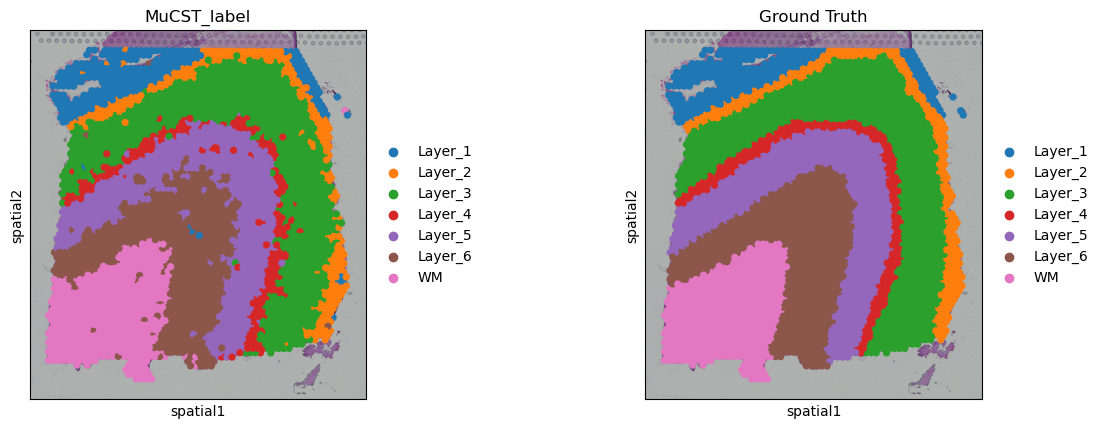

In [20]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

adata_full.obs['predicted_labels'] = predicted_labels
NMI_score = round(normalized_mutual_info_score(adata_full.obs['ground_truth'], adata_full.obs['predicted_labels'], average_method='max'), 3)
ARI_score = round(adjusted_rand_score(adata_full.obs['ground_truth'], adata_full.obs['predicted_labels']), 3)
sc.pl.spatial(adata_full, color=['predicted_labels', 'ground_truth'], title=['MuCST_label', 'Ground Truth'], size=2)

In [21]:
print(ARI_score, NMI_score)

0.807 0.795
